# Technical Challenge: Data Scientist

The following code has been built to deal with a public dataset that has information about hundreds of records pertaining to salaries and a few features that might be correlated to these.

The code has been structured in a long single file, as it has been built using Google Colab, and modularization was not possible with the given configuration.

### The following block imports all the necessary libraries and reads the csv files that form the dataset, and creates a single data frame.

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Read datasets
salary = pd.read_csv('salary.csv')
people = pd.read_csv('people.csv')
descriptions = pd.read_csv('descriptions.csv')

# Create single data frame (filtering our the records with no salary information)
df = people.merge(salary[pd.notnull(salary.Salary)], how='inner').merge(descriptions)

### The following block performs some simple feature engineering steps, to transform the data and derive some new columns into the data frame.

Two assumptions done for the dataset are that with higher years of experience one earns higher salary, and that with higher education level one gets higher salary. The latter one involves a categorical feature, so it is converted into a numerical one in this block, by performing a quadratic regression, so then it can be integrated into a single numerical feature that includes both the experience and the education level.

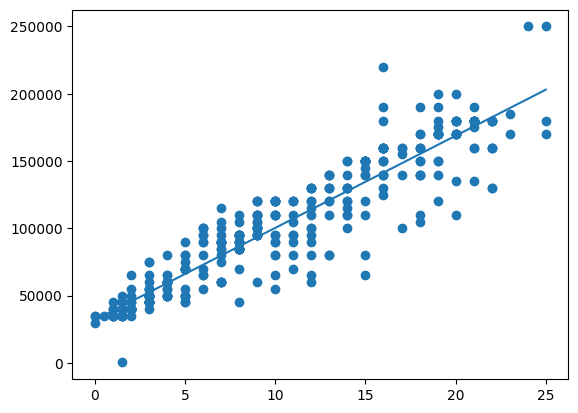

Quadratic regressor:   
6845 x + 3.192e+04
R2-score for quadratic regressor of salary wrt years of experience 0.865528278393677
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      373 non-null    int64  
 1   Age                     370 non-null    float64
 2   Gender                  370 non-null    object 
 3   Education Level         370 non-null    object 
 4   Job Title               370 non-null    object 
 5   Years of Experience     373 non-null    float64
 6   Salary                  373 non-null    float64
 7   Description             370 non-null    object 
 8   BeginWork               370 non-null    float64
 9   JobKeyWord              373 non-null    object 
 10  EducLevelNumeric        373 non-null    float64
 11  EducPlusExp             373 non-null    float64
 12  SalaryScaled        

,id,Age,Years of Experience,Salary,BeginWork,EducLevelNumeric,EducPlusExp,SalaryScaled,YearsExpScaled,AgeScaled,EducPlusExpScaled,SalaryRescaled,YearsExpScaledRescaled,AgeRescaled,EducPlusExpRescaled
count,373.000000,370.000000,373.000000,373.000000,370.000000,373.000000,373.000000,373.000000,373.000000,370.000000,373.000000,373.000000,373.000000,370.000000,373.000000
mean,186.844504,37.437838,10.030831,100577.345845,27.390541,3.760187,13.791018,0.401471,0.401233,0.481261,0.381466,100577.345845,10.030831,37.437838,13.791018
std,108.619601,7.080465,6.557007,48240.013482,1.475929,4.801130,10.172377,0.193231,0.262280,0.236015,0.281372,48240.013482,6.557007,7.080465,10.172377
min,0.000000,23.000000,0.000000,350.000000,22.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,350.000000,0.000000,23.000000,0.000000
25%,93.000000,31.250000,4.000000,55000.000000,26.000000,0.000000,4.000000,0.218906,0.160000,0.275000,0.110642,55000.000000,4.000000,31.250000,4.000000
50%,187.000000,36.000000,9.000000,95000.000000,28.000000,0.000000,11.000000,0.379131,0.360000,0.433333,0.304265,95000.000000,9.000000,36.000000,11.000000
75%,281.000000,44.000000,15.000000,140000.000000,28.000000,8.069703,23.069703,0.559383,0.600000,0.700000,0.638118,140000.000000,15.000000,44.000000,23.069703
max,374.000000,53.000000,25.000000,250000.000000,32.000000,12.152717,36.152717,1.000000,1.000000,1.000000,1.000000,250000.000000,25.000000,53.000000,36.152717


In [2]:
# Function to mark presence of words from the given set
words_to_find = {'Director', 'Senior', 'Junior', 'Manager'}
def mark_words(text, word_set):
    if pd.isna(text):
      return 'NaN'
    found_words = [word for word in word_set if word.lower() in text.lower()]
    return found_words[0] if found_words else 'None'

# Higher degree (for the polynomial regressor) does not sustantially increase performance, while having more risk o over-fitting. Therefore, degree 2 is left (quadratic).
quadraticregressor = np.poly1d(np.polyfit(df['Years of Experience'], df['Salary'], 1))

# Polynomial line visualization
polyline = np.linspace(0, 25, 100)
plt.scatter(df['Years of Experience'], df['Salary'])
plt.plot(polyline, quadraticregressor(polyline))
plt.show()

# See resulting regressor
print('Quadratic regressor: ',quadraticregressor)

# R square metric
print('R2-score for quadratic regressor of salary wrt years of experience',r2_score(df['Salary'], quadraticregressor(df['Years of Experience'])))

# Computing the expected delta for each given education level
deltaphd = (df[df['Education Level']=='PhD']['Salary'].mean()-df[df['Education Level']=='Master\'s']['Salary'].mean())/quadraticregressor[1]
deltamaster = (df[df['Education Level']=='Master\'s']['Salary'].mean()-df[df['Education Level']=='Bachelor\'s']['Salary'].mean())/quadraticregressor[1]

# Create some extra features
df['BeginWork'] = df.Age - df['Years of Experience']
df['JobKeyWord'] = df['Job Title'].apply(lambda x: mark_words(x, words_to_find))
df['EducLevelNumeric'] = df['Education Level'].apply(lambda x: deltaphd+deltamaster if x == 'PhD' else deltamaster if x == 'Master\'s' else 0)
df['EducPlusExp'] = df['EducLevelNumeric']+df['Years of Experience']

# Function to scale and unscale single features (for standard weighing)
def scale(df, newcolname, existingcolname):
  df[newcolname] = (df[existingcolname]-df[existingcolname].min())/(df[existingcolname].max()-df[existingcolname].min())
def unscale(df, scaledcolname, originalcolname, unscaledcolname):
  df[unscaledcolname] = df[originalcolname].min() + (df[originalcolname].max() - df[originalcolname].min()) * df[scaledcolname]

# Create some extra features, which are the scatalation of the existing ones
scale(df, 'SalaryScaled', 'Salary')
scale(df, 'YearsExpScaled', 'Years of Experience')
scale(df, 'AgeScaled', 'Age')
scale(df, 'EducPlusExpScaled', 'EducPlusExp')
# These unscalings were done simply for verification purposes, code is left as a mean to check in case a more complex version of this notebook will be done in the future
unscale(df, 'SalaryScaled', 'Salary', 'SalaryRescaled')
unscale(df, 'YearsExpScaled', 'Years of Experience', 'YearsExpScaledRescaled')
unscale(df, 'AgeScaled', 'Age', 'AgeRescaled')
unscale(df, 'EducPlusExpScaled', 'EducPlusExp', 'EducPlusExpRescaled')

# Just for the purpose of having the null values handy
null_data = df[df.isnull().any(axis=1)]

# See some basic statistics for the dataset
df.info()
df.describe()

### The following block just prints (some parts of) the obtained data frame.

In [3]:
df

,id,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Description,BeginWork,JobKeyWord,EducLevelNumeric,EducPlusExp,SalaryScaled,YearsExpScaled,AgeScaled,EducPlusExpScaled,SalaryRescaled,YearsExpScaledRescaled,AgeRescaled,EducPlusExpRescaled
0,0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0,I am a 32-year-old male working as a Software ...,27.0,None,0.000000,5.000000,0.359103,0.20,0.300000,0.138302,90000.0,5.0,32.0,5.000000
1,1,28.0,Female,Master's,Data Analyst,3.0,65000.0,I am a 28-year-old data analyst with a Master'...,25.0,None,8.069703,11.069703,0.258963,0.12,0.166667,0.306193,65000.0,3.0,28.0,11.069703
2,2,45.0,Male,PhD,Senior Manager,15.0,150000.0,I am a 45-year-old Senior Manager with a PhD a...,30.0,Manager,12.152717,27.152717,0.599439,0.60,0.733333,0.751056,150000.0,15.0,45.0,27.152717
3,3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0,I am a 36-year-old female Sales Associate with...,29.0,None,0.000000,7.000000,0.238935,0.28,0.433333,0.193623,60000.0,7.0,36.0,7.000000
4,4,52.0,Male,Master's,Director,20.0,200000.0,I am a 52-year-old male with over two decades ...,32.0,Director,8.069703,28.069703,0.799720,0.80,0.966667,0.776420,200000.0,20.0,52.0,28.069703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,370,35.0,Female,Bachelor's,Senior Marketing Analyst,8.0,85000.0,As a 35-year-old Senior Marketing Analyst with...,27.0,Senior,0.000000,8.000000,0.339075,0.32,0.400000,0.221284,85000.0,8.0,35.0,8.000000
369,371,43.0,Male,Master's,Director of Operations,19.0,170000.0,I am a 43-year-old male with a Master's degree...,24.0,Director,8.069703,27.069703,0.679551,0.76,0.666667,0.748760,170000.0,19.0,43.0,27.069703
370,372,29.0,Female,Bachelor's,Junior Project Manager,2.0,40000.0,As a 29-year-old female Junior Project Manager...,27.0,Junior,0.000000,2.000000,0.158822,0.08,0.200000,0.055321,40000.0,2.0,29.0,2.000000
371,373,34.0,Male,Bachelor's,Senior Operations Coordinator,7.0,90000.0,As a Senior Operations Coordinator with a Bach...,27.0,Senior,0.000000,7.000000,0.359103,0.28,0.366667,0.193623,90000.0,7.0,34.0,7.000000


### The following block creates some charts to understand the shape and quality of the data (EDA).

The assumptions done above are validated by the high correlation found.

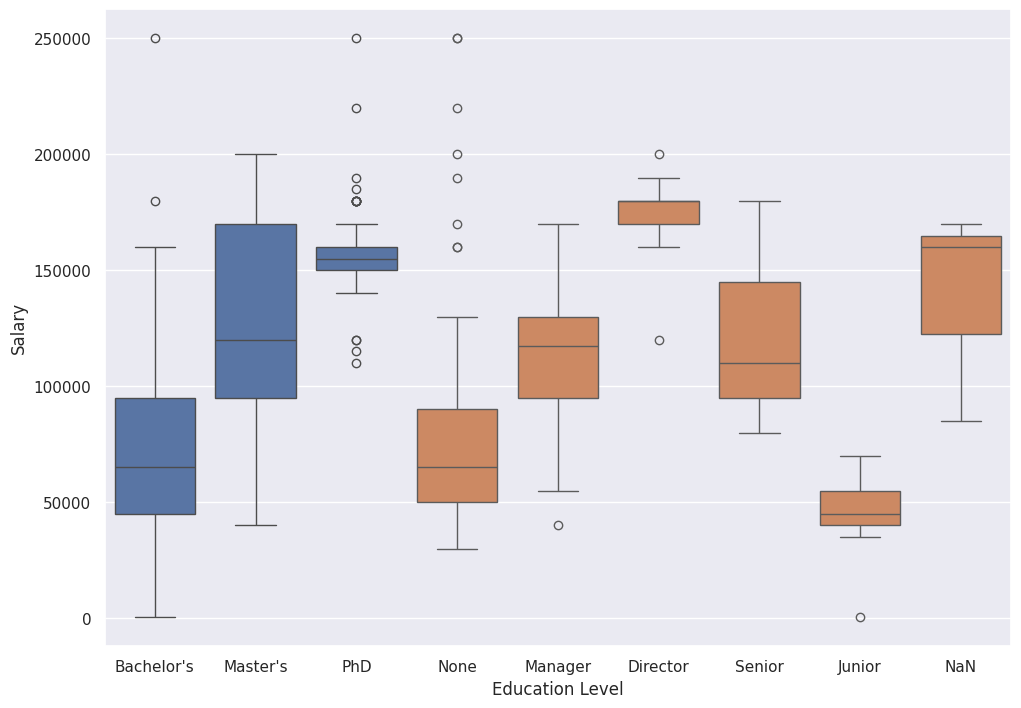

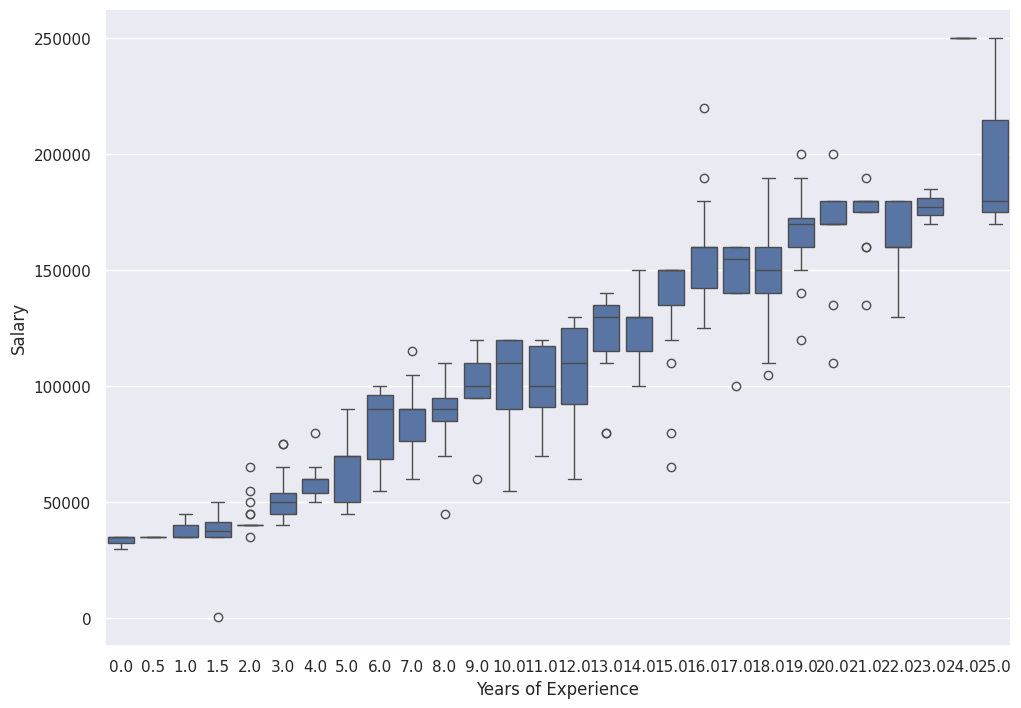

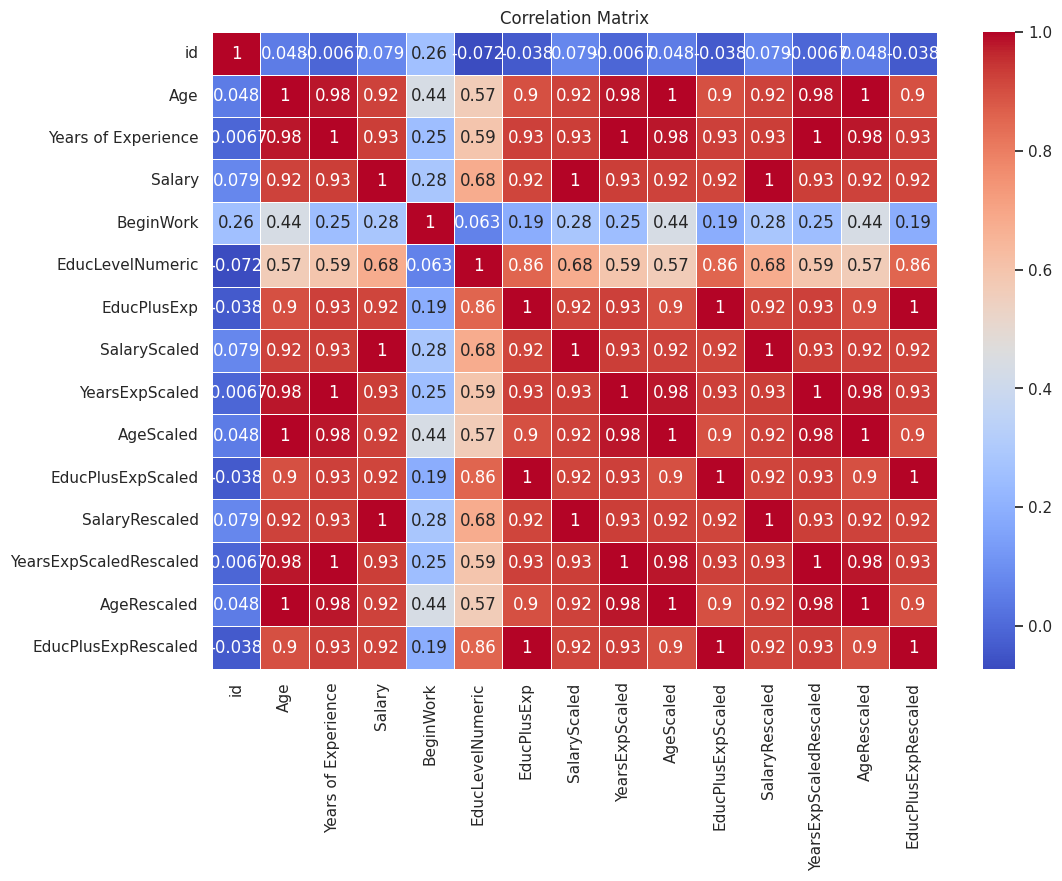

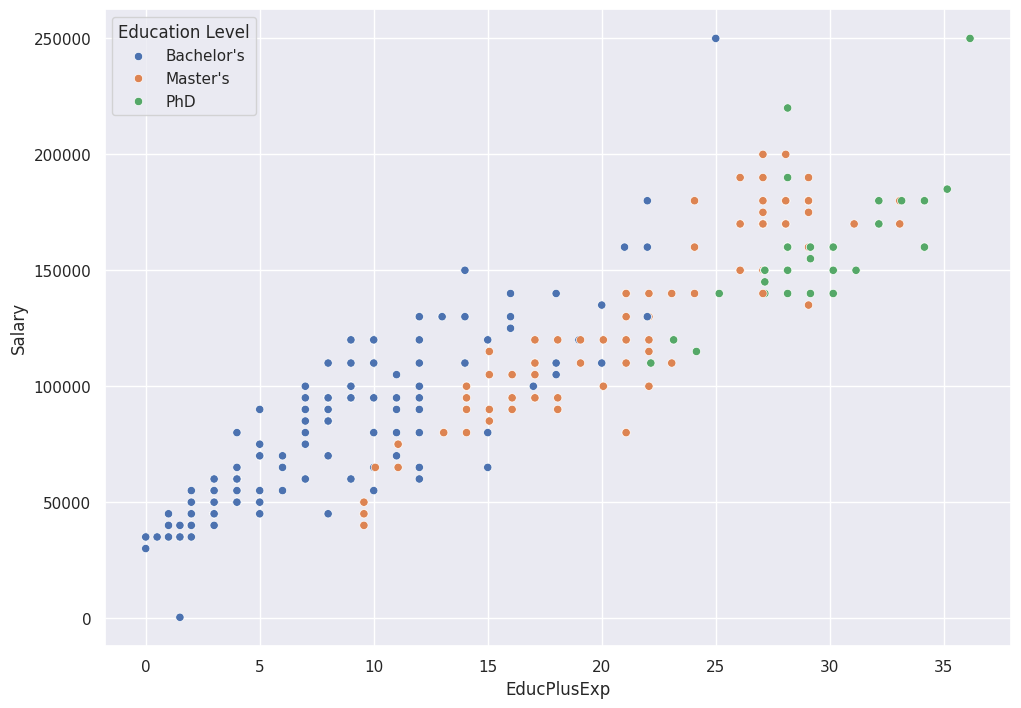

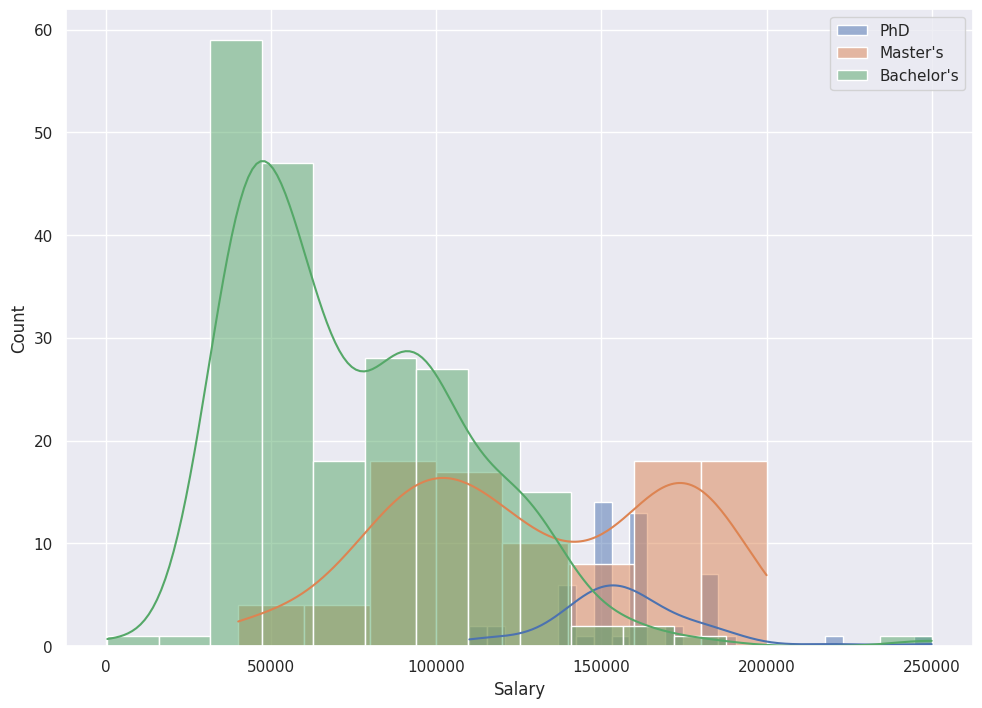

In [4]:
# Visualize how categorical features impact the target variable
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(data = df, x = 'Education Level', y = 'Salary')
sns.boxplot(data = df, x = 'JobKeyWord', y = 'Salary')
plt.show()

# Validate one of the assumptions done above
sns.boxplot(data = df, x = 'Years of Experience', y = 'Salary')
plt.show()

# Correlation matrix for numerical values
numerical_df = df.select_dtypes(np.number)
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Scatter Plot that shows how each of the 3 clusters are somewhat separated
sns.scatterplot(data=df, x='EducPlusExp', y='Salary', hue='Education Level')
plt.show()

# This complements the scatter plot whereas it also shows that the dataset is somewhat skewed, probably due to its size
# Moreover, the dataset shows that for Master's degree the data might also be a little biased by the given cases
sns.histplot(df[df['Education Level']=='PhD']['Salary'], label='PhD', kde=True)
sns.histplot(df[df['Education Level']=='Master\'s']['Salary'], label='Master\'s', kde=True)
sns.histplot(df[df['Education Level']=='Bachelor\'s']['Salary'], label='Bachelor\'s', kde=True)
plt.legend()
plt.show()

### The following block builds the regression models.

The only input variable chosen is the one that includes the information of both the experience and the education level. Variables are used in the scaled version, to compute proper MSE's. A 80/20 split is done in the dataset. A total of 3 regressors are trained: a dummy one, a decision tree, and a neural network (optional feature for the challenge).

The MSE's are shown, and the Decision Tree happens to be better than the Neural Network, but this has been researched and it's just a matter of overfitting with the given train/test split. It's left fixed (with the seed set to 0) just for reproducibility purposes.

In [5]:
# Define the sets
input_feature = ['EducPlusExpScaled']
target_variable = 'SalaryScaled'
X = df[input_feature]
y = df[target_variable]

# Split the data into training and testing (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the dummy regressor and evaluate performance
dummyregressor = DummyRegressor()
dummyregressor.fit(X_train, y_train)
y_pred_dummy = dummyregressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred_dummy)
print(f"Mean Squared Error of Dummy Regressor: {mse}")

# Fit the decision tree regressor and evaluate performance
DTregressor = DecisionTreeRegressor(random_state=0)
DTregressor.fit(X_train, y_train)
y_pred_DT = DTregressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred_DT)
print(f"Mean Squared Error of DT: {mse}")

# Fit the neural network regressor and evaluate performance
NNregressor = MLPRegressor(random_state=0)
NNregressor.fit(X_train, y_train)
y_pred_NN = NNregressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred_NN)
print(f"Mean Squared Error of NN: {mse}")

Mean Squared Error of Dummy Regressor: 0.03337186712714563
Mean Squared Error of DT: 0.003339079204866332
Mean Squared Error of NN: 0.00503231186431306


### The following block plots the actual values for the test cases plus the predicted ones using the 3 regressors.

The chart already allows us to glimpse on the overfitting made by the Decision Tree.

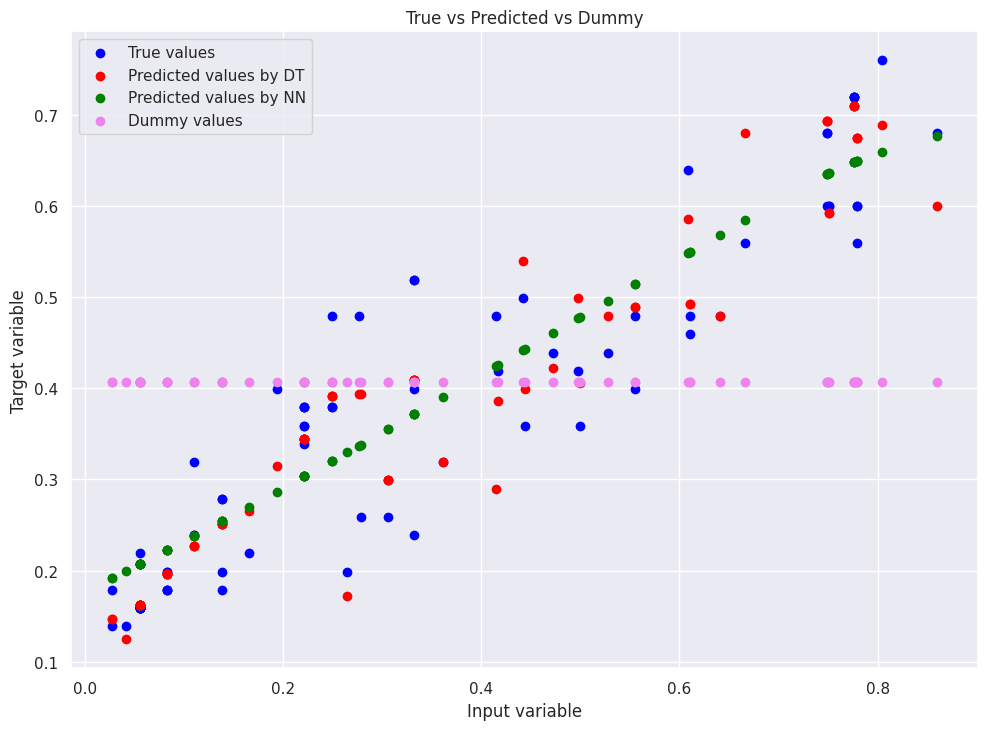

In [6]:
# Plots
plt.scatter(X_test, y_test, color='blue', label='True values')
plt.scatter(X_test, y_pred_DT, color='red', label='Predicted values by DT')
plt.scatter(X_test, y_pred_NN, color='green', label='Predicted values by NN')
plt.scatter(X_test, y_pred_dummy, color='violet', label='Dummy values')
plt.xlabel('Input variable')
plt.ylabel('Target variable')
plt.title('True vs Predicted vs Dummy')
plt.legend()
plt.show()

### The following block performs a cross-validation (optional feature for the challenge) over 5 different splits of the dataset, using the neural network model.

The metrics (standard deviation plus 5 MSE's) show us that any splitting of the dataset produces almost similar results. Doing the same with the decision tree model (not left in the code) results in a more varied outcome, which is another evidence of possible overfitting depending on the specific split done over the dataset.

In [7]:
# Cross validation
cv_scores = cross_val_score(NNregressor, X, y, cv=5, scoring='neg_mean_squared_error')

# Print results
print(f"Cross-validation scores (negative MSE): {cv_scores}")
print(f"Average cross-validation score: {np.mean(cv_scores)}")
print(f"Standard deviation of cross-validation scores: {np.std(cv_scores)}")
positive_cv_scores = -cv_scores
print(f"Positive MSE scores: {positive_cv_scores}")

Cross-validation scores (negative MSE): [-0.00815034 -0.00864768 -0.00385483 -0.00518895 -0.00620522]
Average cross-validation score: -0.006409402091424399
Standard deviation of cross-validation scores: 0.0017943102938854177
Positive MSE scores: [0.00815034 0.00864768 0.00385483 0.00518895 0.00620522]


### The following block computes the predicted values for the entire dataset plus the errors obtained (both in absolute value and in percentage).

An unscaling is done, so the results can be easily understood by humans. The dataset is shown (part of).

In [8]:
# Add prediction results to the data frame
df['Predictions'] = NNregressor.predict(X)
unscale(df, 'Predictions', 'Salary', 'PREDICTED')
df['ERROR'] = abs(df['Salary']-df['PREDICTED'])
df['ERRORPerc'] = df['ERROR']/df['Salary']*100
df

,id,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Description,BeginWork,JobKeyWord,...,AgeScaled,EducPlusExpScaled,SalaryRescaled,YearsExpScaledRescaled,AgeRescaled,EducPlusExpRescaled,Predictions,PREDICTED,ERROR,ERRORPerc
0,0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0,I am a 32-year-old male working as a Software ...,27.0,None,...,0.300000,0.138302,90000.0,5.0,32.0,5.000000,0.254124,63792.133800,26207.866200,29.119851
1,1,28.0,Female,Master's,Data Analyst,3.0,65000.0,I am a 28-year-old data analyst with a Master'...,25.0,None,...,0.166667,0.306193,65000.0,3.0,28.0,11.069703,0.355767,89167.116856,24167.116856,37.180180
2,2,45.0,Male,PhD,Senior Manager,15.0,150000.0,I am a 45-year-old Senior Manager with a PhD a...,30.0,Manager,...,0.733333,0.751056,150000.0,15.0,45.0,27.152717,0.636183,159173.032785,9173.032785,6.115355
3,3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0,I am a 36-year-old female Sales Associate with...,29.0,None,...,0.433333,0.193623,60000.0,7.0,36.0,7.000000,0.286463,71865.611021,11865.611021,19.776018
4,4,52.0,Male,Master's,Director,20.0,200000.0,I am a 52-year-old male with over two decades ...,32.0,Director,...,0.966667,0.776420,200000.0,20.0,52.0,28.069703,0.648398,162222.470125,37777.529875,18.888765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,370,35.0,Female,Bachelor's,Senior Marketing Analyst,8.0,85000.0,As a 35-year-old Senior Marketing Analyst with...,27.0,Senior,...,0.400000,0.221284,85000.0,8.0,35.0,8.000000,0.303332,76076.851861,8923.148139,10.497821
369,371,43.0,Male,Master's,Director of Operations,19.0,170000.0,I am a 43-year-old male with a Master's degree...,24.0,Director,...,0.666667,0.748760,170000.0,19.0,43.0,27.069703,0.634928,158859.762499,11140.237501,6.553081
370,372,29.0,Female,Bachelor's,Junior Project Manager,2.0,40000.0,As a 29-year-old female Junior Project Manager...,27.0,Junior,...,0.200000,0.055321,40000.0,2.0,29.0,2.000000,0.207191,52075.243558,12075.243558,30.188109
371,373,34.0,Male,Bachelor's,Senior Operations Coordinator,7.0,90000.0,As a Senior Operations Coordinator with a Bach...,27.0,Senior,...,0.366667,0.193623,90000.0,7.0,34.0,7.000000,0.286463,71865.611021,18134.388979,20.149321


### The following block creates a chart to visually understand the errors (in percentage) committed by the regressor.

A preliminary view on the chart might make one think that a representative amount of cases has a somewhat high percentage of error (ca. 20-40%).

However, a large percentage of these cases are on the left part of the chart (lower salaries), whereas in the middle part of the chart, the majority of cases have a lower error percentage (ca. < 20%). The right part of the chart corresponds to the few cases in the tail, so not weighing much.

Due to the explanation of the previous paragraph is that one should now understand why the MSE is very low (ca. 0.005, which means roughly 7%), as it is computed on (a scaled version of) the absolute values (not on the percentages of salary).

Finally, a few outliers are presented, even though these have not been removed during the entire training/testing/validation of the models.

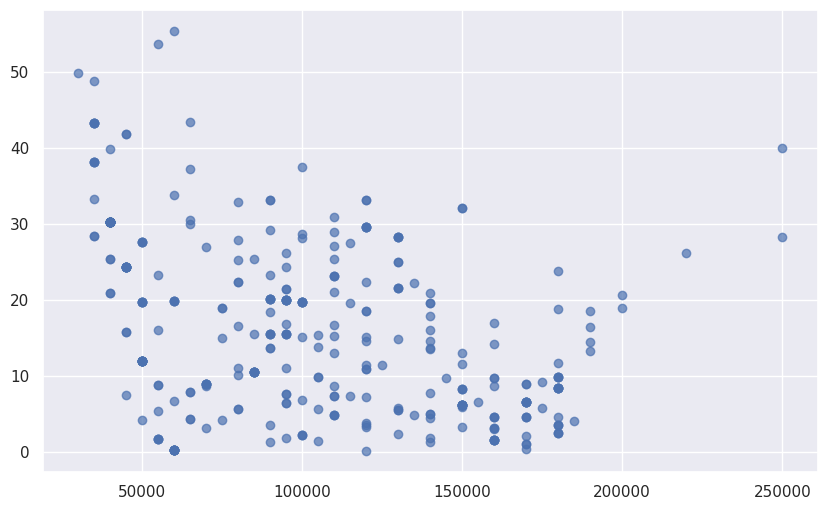

,id,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Description,BeginWork,JobKeyWord,...,AgeScaled,EducPlusExpScaled,SalaryRescaled,YearsExpScaledRescaled,AgeRescaled,EducPlusExpRescaled,Predictions,PREDICTED,ERROR,ERRORPerc
43,43,36.0,Female,Bachelor's,Administrative Assistant,8.0,45000.0,I am a 36-year-old female Administrative Assis...,28.0,None,...,0.433333,0.221284,45000.0,8.0,36.0,8.000000,0.303332,76076.851861,31076.851861,69.059671
81,81,41.0,Female,Master's,Data Analyst,13.0,80000.0,I am a 41-year-old female with a Master's degr...,28.0,None,...,0.600000,0.582797,80000.0,13.0,41.0,21.069703,0.531760,133103.776532,53103.776532,66.379721
104,104,39.0,Female,Master's,Senior Project Coordinator,13.0,80000.0,I am a 39-year-old Senior Project Coordinator ...,26.0,Senior,...,0.533333,0.582797,80000.0,13.0,39.0,21.069703,0.531760,133103.776532,53103.776532,66.379721
116,116,40.0,Female,Bachelor's,Office Manager,15.0,65000.0,As a 40-year-old professional with a Bachelor'...,25.0,Manager,...,0.566667,0.414907,65000.0,15.0,40.0,15.000000,0.424289,106273.790783,41273.790783,63.498140
144,144,25.0,Female,Master's,Junior Marketing Specialist,1.5,40000.0,I am a 25-year-old Junior Marketing Specialist...,23.5,Junior,...,0.066667,0.264702,40000.0,1.5,25.0,9.569703,0.329811,82687.250130,42687.250130,106.718125
173,174,26.0,Female,Master's,Junior Data Scientist,1.5,45000.0,I am a 26-year-old female Junior Data Scientis...,24.5,Junior,...,0.100000,0.264702,45000.0,1.5,26.0,9.569703,0.329811,82687.250130,37687.250130,83.749445
202,203,27.0,Female,Master's,Junior UX Designer,1.5,45000.0,I am a 27-year-old female working as a Junior ...,25.5,Junior,...,0.133333,0.264702,45000.0,1.5,27.0,9.569703,0.329811,82687.250130,37687.250130,83.749445
231,232,27.0,Female,Master's,Junior Research Scientist,1.5,50000.0,I am a 27-year-old female working as a Junior ...,25.5,Junior,...,0.133333,0.264702,50000.0,1.5,27.0,9.569703,0.329811,82687.250130,32687.250130,65.374500
258,259,29.0,Male,Bachelor's,Junior Business Operations Analyst,1.5,350.0,As a 29-year-old Junior Business Operations An...,27.5,Junior,...,0.200000,0.041491,350.0,1.5,29.0,1.500000,0.199421,50135.395749,49785.395749,14224.398785


In [9]:
# Set threshold for chart and to show outliers
percthresh = 60

# Build figure
plt.figure(figsize=(10, 6))
plt.plot(df.Salary[df.ERRORPerc < percthresh],df.ERRORPerc[df.ERRORPerc < percthresh], marker='o', linestyle='', color='b', alpha=0.7)
plt.show()

# Show outlier records
df[df.ERRORPerc > percthresh]